In [ ]:
from nbdev import *
%nbdev_default_export source_data
%reload_ext autoreload
%autoreload 2

Cells will be exported to wtlike.source_data,
unless a different module is specified after an export flag: `%nbdev_export special.module`


# Source Data management
> Extract data for a source

### Overview

Given a point source, the class `SourceData` manages all data-oriented operations

In [ ]:
%nbdev_export
import numpy as np
import pandas as pd
import healpy
import pickle
from pathlib import Path

from wtlike.config import *
from wtlike.effective_area import *
from wtlike.weights import *

In [ ]:
%nbdev_hide
# check the weekly files

weekly_folder = Path('/home/burnett/weekly')
week_files = ff = sorted(list(weekly_folder.glob('*.pkl')))
wk = list(map(lambda f: int(os.path.splitext(f)[0][-3:])-9, ff))
print(f'Weekly folder "{weekly_folder}" contains {len(wk)} weeks, last=#{max(wk)}')

filename =  ff[-1]
source = PointSource('Geminga')
config = Config(verbose=3)
config.weekly_folder = weekly_folder



Weekly folder "/home/burnett/weekly" contains 659 weeks, last=#659


In [ ]:
%nbdev_export
def _exposure(config,  livetime, pcosine):
    """return exposure calculated for each pair in livetime and cosines arrays

    uses effective area
    """
    from scipy.integrate import simps
    assert len(livetime)==len(pcosine), 'expect equal-length arrays'

    # get a set of energies and associated weights from a trial spectrum

    emin,emax = config.energy_range
    loge1=np.log10(emin); loge2=np.log10(emax)

    edom=np.logspace(loge1, loge2, int((loge2-loge1)*config.bins_per_decade+1))
    if config.verbose>1:
        print(f'Calculate exposure using the energy domain'\
              f' {emin}-{emax} {config.bins_per_decade} bins/decade' )
    base_spectrum = eval(config.base_spectrum) #lambda E: (E/1000)**-2.1
    assert base_spectrum(1000)==1.
    wts = base_spectrum(edom)

    # effectivee area function from
    ea = EffectiveArea(file_path=config.files.aeff)

    # a table of the weighted for each pair in livetime and pcosine arrays
    rvals = np.empty([len(wts),len(pcosine)])
    for i,(en,wt) in enumerate(zip(edom,wts)):
        faeff,baeff = ea([en],pcosine)
        rvals[i] = (faeff+baeff)*wt

    aeff = simps(rvals,edom,axis=0)/simps(wts,edom)
    return (aeff*livetime)

def _calculate_exposure_for_source(config, source, week):
    """
    Calcualate the exposure for the source during the given week
    """
    df = week['sc_data']
    
    # calculate cosines with respect to sky direction
    sc = source
    ra_r,dec_r = np.radians(sc.ra), np.radians(sc.dec)
    sdec, cdec = np.sin(dec_r), np.cos(dec_r)

    def cosines( ra2, dec2):
        ra2_r =  np.radians(ra2.values)
        dec2_r = np.radians(dec2.values)
        return np.cos(dec2_r)*cdec*np.cos(ra_r-ra2_r) + np.sin(dec2_r)*sdec

    pcosines = cosines(df.ra_scz,    df.dec_scz)
    zcosines = cosines(df.ra_zenith, df.dec_zenith)
    # mask out entries too close to zenith, or too far away from ROI center
    mask =   (pcosines >= config.cos_theta_max) & (zcosines>=np.cos(np.radians(config.z_max)))
    if config.verbose>1:
        print(f'\tFound {len(mask):,} S/C entries:  {sum(mask):,} remain after zenith and theta cuts')
    dfm = df.loc[mask,:]
    livetime = dfm.livetime.values

    return  pd.DataFrame( 
        dict(
            start=df.start[mask], 
            stop=df.stop[mask], 
            exp=_exposure(config, livetime, pcosines[mask])
        ))




In [ ]:
%nbdev_hide
week = pickle.load( open(filename,'rb') )
e_df = _calculate_exposure_for_source(config, source, week); 
e_df.head()

	Found 17,021 S/C entries:  5,526 remain after zenith and theta cuts
Calculate exposure using the energy domain 100.0-1000000.0 4 bins/decade


,start,stop,exp
24,59291.051606,59291.051954,31624.450646
25,59291.051954,59291.052301,32398.618161
26,59291.052301,59291.052648,32953.126382
27,59291.052648,59291.052995,33493.221494
28,59291.052995,59291.053342,33896.887531


In [ ]:
%nbdev_export

def _get_photons_near_source(config, source, week): #tzero, photon_df):
    """
    Select the photons near a source
    
    - source : a PointSource object
    - week : dict with 
        - tzero : start time for the photon
        - photon_df : DataFrame with photon data
    
    Returns a DF with 
    - `band` index, 
    - `time` in MJD (added tstart and converted from MET)
    - `pixel` index, nest indexing 
    - `radius` distance in deg from source direction
    """
    
    def _cone(config, source, nest=True):
        # cone geometry stuff: get corresponding pixels and center vector
        l,b,radius = source.l, source.b, config.radius
        cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
        conepix = healpy.query_disc(config.nside, cart(l,b), np.radians(radius), nest=nest)
        center = healpy.dir2vec(l,b, lonlat=True)
        return center, conepix
    
    center, conepix = _cone(config,source)

    df = week['photons']
    tstart = week['tstart']
    allpix = df.nest_index.values

    # select by comparing high-order pixels (faster)
    shift=11
    a = np.right_shift(allpix, shift)
    c = np.unique(np.right_shift(conepix, shift))
    incone = np.isin(a,c)

    if config.verbose>2:
        a, b = sum(incone), len(allpix)
        print(f'Select photons for source {source.name}:\n\tPixel cone cut: select {a} from {b} ({100*a/b:.1f}%)')

    # cut df to entries in the cone
    dfc = df[incone]

    # distance from center for all accepted photons
    ll,bb = healpy.pix2ang(config.nside, dfc.nest_index,  nest=True, lonlat=True)
    cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
    t2 = np.degrees(np.array(np.sqrt((1.-np.dot(center, cart(ll,bb)))*2), np.float32))
    in_cone = t2<config.radius

    if config.verbose>2:
        print(f'\tGeometric cone cut: select {sum(in_cone)}')
    # assume all in the GTI (should check)

    # times: convert to float, add tstart, convert to MJD
    time = MJD(np.array(dfc.time, float)+tstart)

    # assemble the DataFrame, remove those outside the radius
    out_df = pd.DataFrame(np.rec.fromarrays(
        [np.array(dfc.band), time, dfc.nest_index, t2],
        names='band time pixel radius'.split()))[in_cone]
    return out_df

In [ ]:
%nbdev_hide
week = pickle.load(open(ff[0],'rb')); 
tstart = week['tstart']
print(tstart, UTC(MJD(tstart)))
p_df = _get_photons_near_source(config, source, week )
p_df.head()

239557417.0 2008-08-04 15:44
Select photons for source Geminga:
	Pixel cone cut: select 2138 from 104927 (2.0%)
	Geometric cone cut: select 1606


,band,time,pixel,radius
1,6,54682.657022,6738278,0.698381
2,3,54682.657934,6761152,2.498099
4,4,54682.658637,6739138,0.290310
5,1,54682.658760,6714890,3.276757
6,0,54682.658997,6734033,5.024745


In [ ]:
%nbdev_export
def get_default_bins(config, exposure):
    """set up default bins from exposure; and config.mjd_range if set.
    
    adjust stop to come out even,    round to whole day
    """

    start = np.round(exposure.start.values[0])
    stop =  np.round(exposure.stop.values[-1])
    if config.mjd_range is None:
        config.mjd_range = (start,stop)

    step = config.time_interval
    nbins = int(round((stop-start)/step))
    tb =time_bins = np.linspace(start, stop, nbins+1)
    if config.verbose>0:
        print(f'Time bins: {nbins} intervals of {step} days, '\
              f'in range ({time_bins[0]:.1f}, {time_bins[-1]:.1f})')
    return time_bins        

def _load_from_weekly_data(config, source):
    
    # check weights
    weight_file =  check_weights(config,  source)
    assert weight_file is not None
    
    weekly_folder = config.weekly_folder
    week_files = sorted(list(weekly_folder.glob('*.pkl')))
    wk = list(map(lambda f: int(os.path.splitext(f)[0][-3:])-9, week_files))

    if config.verbose>1:
        print(f"Assembling photon data and exposure for source {source.name} from"\
              f' folder "{weekly_folder}", with {len(wk)} weeks, last=#{max(wk)}')

    verbose, config.verbose=config.verbose, 0
    # list of data framees
    pp = []
    ee = []
    for f in week_files:
        print('.', end='')
        with open(f, 'rb') as inp:
            week = pickle.load(inp)
        pp.append(_get_photons_near_source(config, source, week ))
        ee.append(_calculate_exposure_for_source(config, source, week ))
    print('');    
    config.verbose=verbose
    # concatenate the two lists of DataFrames
    p_df = pd.concat(pp, ignore_index=True)
    e_df = pd.concat(ee, ignore_index=True)

    if config.verbose>1:
        times = p_df.time.values
        print(f'Loaded {len(p_df):,} photons from {UTC(times[0])} to  {UTC(times[-1])} ')
        print(f'Calculated {len(e_df):,} exposure entries')
        
    # add weights to photon data
    add_weights(config, p_df, source)
        
    return p_df, e_df

class SourceData(object):
    
    def __init__(self, config, source, clear=False):
        """ return concatenated photon data near the source and associated exposure
        from  config.weekly_folder, the Path to folder with list of pickle files with weekly data
        or cache

        """
        verbose = config.verbose
        self.config = config
        self.source = source
        
        key = f'{source.name}_data'
        self.p_df, self.e_df = config.cache(key, 
                                    _load_from_weekly_data, config, source, 
                                    overwrite=clear,
                                    description=f'photons and exposure for {source.name}')
    
    def binned_exposure(self, time_bins=None):
        """Bin the exposure
        
        - time_bins: list of edges. if None, construct from exposure time limits 
        
        return:
        
        - bexp: array of exposure integrated over each time bin, normalized to total
        - time_bins

        """
        config = self.config

        # get exposure calculation
        exp   = self.e_df.exp.values
        estart= self.e_df.start.values
        estop = self.e_df.stop.values

        # determine bins, using config.time_interval, range of times
            # default bins depends on exposure
        if time_bins is None:
            time_bins = get_default_bins(config, self.e_df)

        #use cumulative exposure to integrate over larger periods
        cumexp = np.concatenate(([0],np.cumsum(exp)) )

        # get index into tstop array of the bin edges
        edge_index = np.searchsorted(estop, time_bins)
        # return the exposure integrated over the intervals
        cum = cumexp[edge_index]

        bexp = np.diff(cum)/(cum[-1]-cum[0]) * (len(time_bins)-1) 
        if config.verbose>0:
            print(f'Relative exposure per bin:\n{pd.Series(bexp).describe(percentiles=[])}')
        return bexp, time_bins
    

## Test extracting full dataset

In [ ]:
config.verbose=2
sd = SourceData(config, source, clear=False)

photons and exposure for Geminga: Saving to cache with key "Geminga_data"
Assembling photon data and exposure for source Geminga from folder "/home/burnett/weekly", with 659 weeks, last=#659
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Loaded 2,367,525 photons from 2008-08-04 15:46 to  2021-03-25 00:07 
Calculated 3,089,248 exposure entries
Load weights from file /mnt/c/users/thbur/

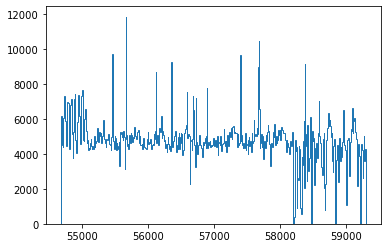

In [ ]:
plt.hist(sd.p_df.time.values, 500, histtype='step');

In [ ]:
%time exp, bins = sd.binned_exposure(); 
exp.mean(), exp.std()

Time bins: 4615 intervals of 1 days, in range (54683.0, 59298.0)
Relative exposure per bin:
count    4615.000000
mean        1.000000
std         0.353521
min         0.000000
50%         0.992487
max         3.663381
dtype: float64
CPU times: user 7.97 ms, sys: 9.01 ms, total: 17 ms
Wall time: 15.6 ms


(1.0, 0.35348259847489344)

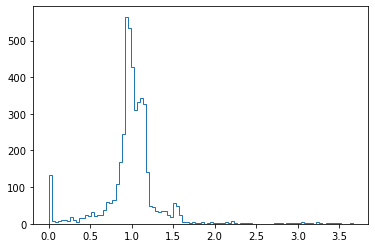

In [ ]:
plt.hist(exp, 100);

In [ ]:
sd.p_df.head()

,band,time,pixel,radius,weight
0,6,54682.657022,6738278,0.698381,0.782784
1,3,54682.657934,6761152,2.498099,NaN
2,4,54682.658637,6739138,0.290310,0.955831
3,1,54682.658760,6714890,3.276757,NaN
4,0,54682.658997,6734033,5.024745,0.078618
